In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [111]:
images = {'train': [], 'val': []}
masks = {'train': [], 'val': []}

import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images/Train')):
    if root.endswith('_Dermoscopic_Image'):
        images['train'].append(os.path.join(root, files[0]))
    if root.endswith('_lesion'):
        masks['train'].append(os.path.join(root, files[0]))

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images/Validation')):
    if root.endswith('_Dermoscopic_Image'):
        images['val'].append(os.path.join(root, files[0]))
    if root.endswith('_lesion'):
        masks['val'].append(os.path.join(root, files[0]))

print(len(images['train']))
print(len(images['val']))

180
20


In [4]:
from torch.utils.data import Dataset
import cv2

class LesionsDataset(Dataset):
    def __init__(self, images, masks, augmentations=None, preprocessing=None):
        self.images = images.copy()
        self.masks = masks.copy()

        assert len(self.images) == len(self.masks), "Length of images' vector must be the same as the length of masks' vector"
        
        self.augmentations = augmentations
        self.preprocessing = preprocessing
        
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
        
        return image, mask
        
    def __len__(self):
        return len(self.masks)

In [105]:
def visualize(image, mask, pred=None):
    if pred is not None:
        _, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(image)
        axes[1].imshow(mask)
        axes[2].imshow(pred)
    else:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image)
        axes[1].imshow(mask)
    plt.show()

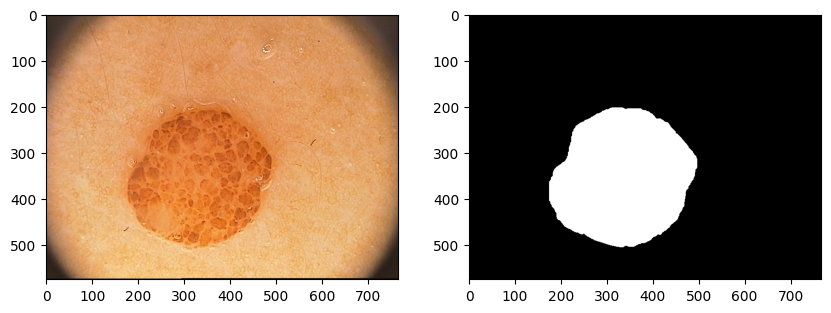

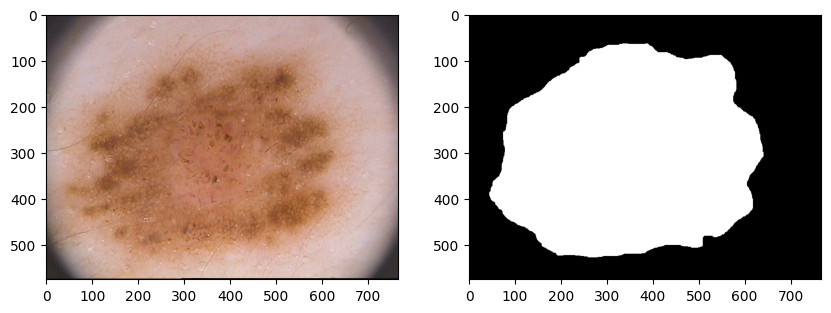

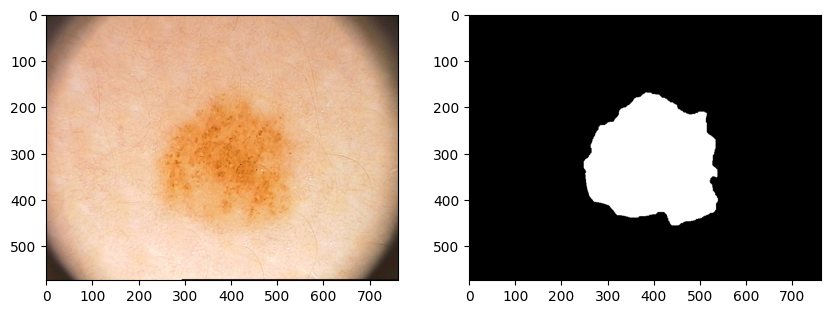

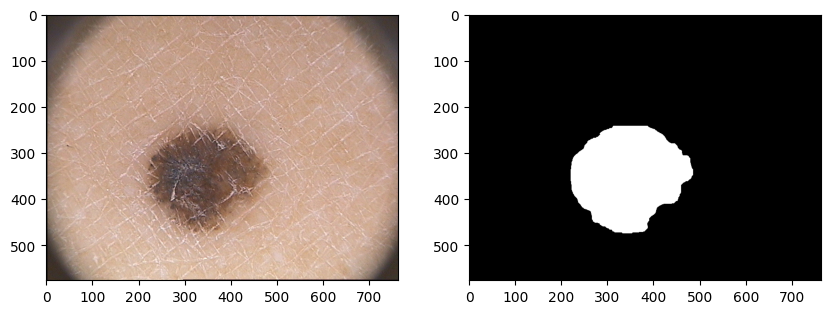

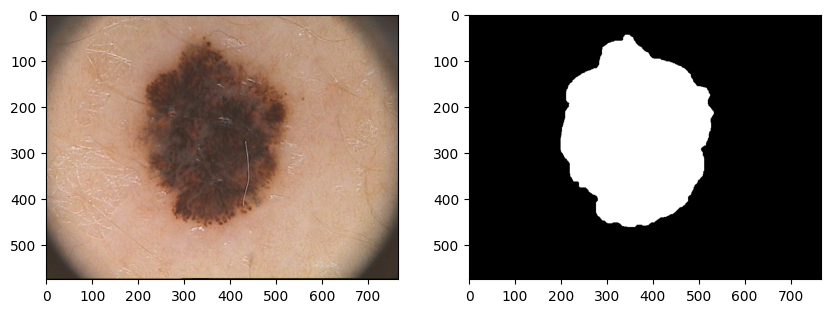

In [77]:
import albumentations as A
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

augmentations = {
    'train': A.Compose([
        A.SmallestMaxSize(max_size=280, always_apply=True),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30),
        A.HorizontalFlip(p=0.5),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.OneOf([
            A.Sharpen(p=0.5),
            A.Blur(p=0.5)
        ], p=0.75),
        A.GaussNoise(p=0.5),
    ]),
    'val': A.Compose([
        A.SmallestMaxSize(max_size=280, always_apply=True),
        A.CenterCrop(height=256, width=256, always_apply=True),
    ])
}

def normalize(img, **kwargs):
    return img.astype("float32") / 255

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

preprocessing = A.Compose([
    #A.Lambda(image=smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet'), always_apply=True),
    #A.Normalize(always_apply=True),
    A.Lambda(image=normalize, mask=normalize, always_apply=True),
    A.Lambda(image=to_tensor, mask=to_tensor, always_apply=True)
])

train_dataset = LesionsDataset(images['train'], masks['train'], augmentations['train'], preprocessing)
valid_dataset = LesionsDataset(images['val'], masks['val'], augmentations['val'], preprocessing)

simple_dataset = LesionsDataset(images['train'], masks['train'])
for _ in range(5):
    idx = np.random.randint(len(simple_dataset))
    image, mask = simple_dataset[idx]
    visualize(image, mask)

In [78]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False)

In [79]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

In [80]:
model = smp.Unet(
    encoder_name='resnet18',
    classes=1,
    activation=None
).to(DEVICE)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [81]:
epochs = 20
init_lr = 2e-4
lr_step = 5
lr_coef = 0.5

metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

criterion = utils.losses.DiceLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=init_lr)
])

In [82]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [83]:
for inputs, answers in train_loader:
    print("Inputs:", inputs)
    print("Answers:", answers)
    break

Inputs: tensor([[[[0.2902, 0.4157, 0.2471,  ..., 0.8118, 0.7882, 0.8000],
          [0.2784, 0.2824, 0.3961,  ..., 0.7765, 0.8078, 0.7373],
          [0.3686, 0.3608, 0.3843,  ..., 0.7490, 0.8196, 0.7451],
          ...,
          [0.5294, 0.5098, 0.6471,  ..., 0.8941, 0.8588, 0.9294],
          [0.5373, 0.5882, 0.5843,  ..., 0.9451, 0.9216, 0.9137],
          [0.5020, 0.5686, 0.5333,  ..., 0.8863, 0.8353, 0.8941]],

         [[0.2275, 0.3647, 0.1922,  ..., 0.6431, 0.5804, 0.6353],
          [0.2157, 0.2510, 0.3294,  ..., 0.6118, 0.6196, 0.5882],
          [0.3373, 0.3294, 0.3059,  ..., 0.5529, 0.6392, 0.5686],
          ...,
          [0.4000, 0.4196, 0.5373,  ..., 0.8000, 0.7686, 0.8118],
          [0.4157, 0.4745, 0.4549,  ..., 0.8471, 0.8314, 0.8157],
          [0.3725, 0.4588, 0.4431,  ..., 0.8157, 0.7412, 0.7725]],

         [[0.2706, 0.3725, 0.2039,  ..., 0.5725, 0.5294, 0.5882],
          [0.2314, 0.2314, 0.3098,  ..., 0.5529, 0.5137, 0.4863],
          [0.2863, 0.2588, 0.2471,

In [84]:
max_score = 0.0
loss_logs = {'train': [], 'val': []}
metric_logs = {'train': [], 'val': []}
for epoch in range(1, epochs + 1):
    print(f'Epoch: {epoch}')
    
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric_f1, train_metric_IOU = list(train_logs.values())
    loss_logs['train'].append(train_loss)
    metric_logs['train'].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    valid_loss, valid_metric_f1, valid_metric_IOU = list(valid_logs.values())
    loss_logs['val'].append(valid_loss)
    metric_logs['val'].append(valid_metric_IOU)

    if valid_logs['iou_score'] > max_score:
        max_score = valid_logs['iou_score']
        trace_image = torch.randn(batch_size, 3, 256, 256)
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE))
        torch.jit.save(traced_model, 'best_model.pt')
        #m = torch.jit.script(model)
        #m.save('best_model.pt')
        print("Model saved!")

    print(f"LR: {optimizer.param_groups[0]['lr']}")
    if epoch % lr_step == 0:
        print("Decreasing decoder learning rate")
        optimizer.param_groups[0]['lr'] *= lr_coef

Epoch: 1
valid: 100%|███████████████████| 1/1 [00:00<00:00,  6.90it/s, dice_loss - -0.2063, fscore - 0.9527, iou_score - 0.9096]
Model saved!
LR: 0.0002
Epoch: 2
valid: 100%|█████████████████████| 1/1 [00:00<00:00,  6.91it/s, dice_loss - -0.7995, fscore - 1.073, iou_score - 1.158]
Model saved!
LR: 0.0002
Epoch: 3
valid: 100%|████████████████████████| 1/1 [00:00<00:00,  6.83it/s, dice_loss - -1.52, fscore - 1.14, iou_score - 1.325]
Model saved!
LR: 0.0002
Epoch: 4
valid: 100%|██████████████████████| 1/1 [00:00<00:00,  6.86it/s, dice_loss - -2.091, fscore - 1.178, iou_score - 1.433]
Model saved!
LR: 0.0002
Epoch: 5
valid: 100%|██████████████████████| 1/1 [00:00<00:00,  4.48it/s, dice_loss - -2.379, fscore - 1.214, iou_score - 1.544]
Model saved!
LR: 0.0002
Decreasing decoder learning rate
Epoch: 6
valid: 100%|██████████████████████| 1/1 [00:00<00:00,  6.68it/s, dice_loss - -2.212, fscore - 1.237, iou_score - 1.621]
Model saved!
LR: 0.0001
Epoch: 7
valid: 100%|███████████████████████| 1/1

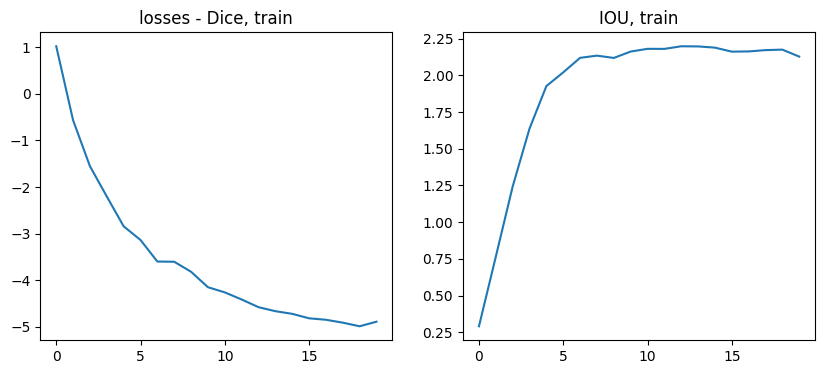

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs['train'], label = 'train')
axes[0].set_title('losses - Dice, train')

axes[1].plot(metric_logs['train'], label = 'train')
axes[1].set_title('IOU, train')

plt.show()

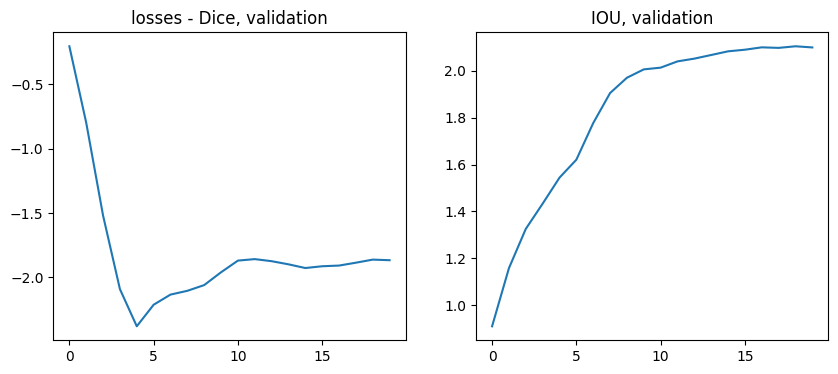

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs['val'], label = 'val')
axes[0].set_title('losses - Dice, validation')

axes[1].plot(metric_logs['val'], label = 'val')
axes[1].set_title('IOU, validation')

plt.show()

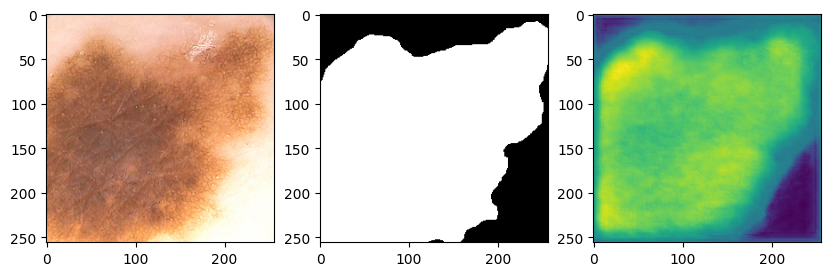

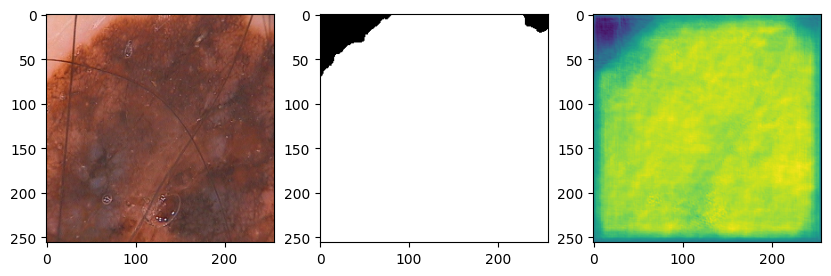

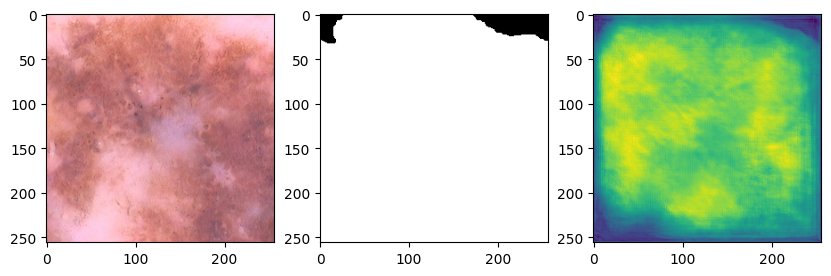

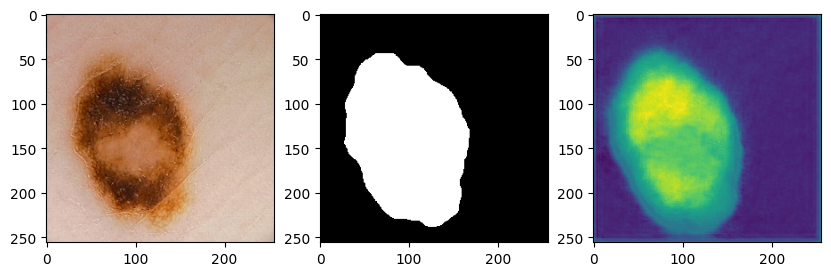

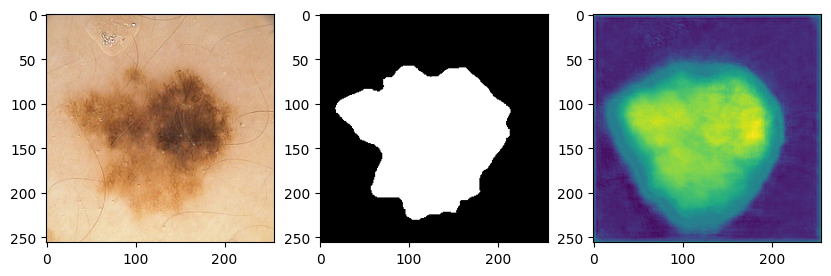

In [110]:
best_model = torch.jit.load('best_model.pt', map_location=DEVICE)
for _ in range(5):
    idx = np.random.randint(len(valid_dataset))
    image, real_mask = valid_dataset[idx]
    X = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model(X)
    image = image.transpose(1, 2, 0)
    real_mask = real_mask.transpose(1, 2, 0)
    visualize(image, real_mask, pred_mask.cpu().detach().squeeze())